## 3. Orbits of Comets

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from nm4p.rk4 import rk4
from nm4p.rka import rka
plt.style.use('default')

In [6]:
def gravrk(s, t, GM):
    '''Returns RHS of Kepler ODE; used by runge-kutta algorithms.

    Inputs:
    s - state vector   [r1 r2 v1 v2]
    t - time (not used)
    GM - parameter G*M 
    
    Output:
    deriv - Derivatives of the state vector'''
    
    # Compute acceleration
    r = np.array([s[0], s[1]])
    v = np.array([s[2], s[3]])
    accel = -GM * r / np.linalg.norm(r)**3

    # return derivatives
    derivs = np.array([v[0], v[1], accel[0], accel[1]])
    return derivs

C:\Users\frase\AppData\Local\Temp\ipykernel_8252\1673179643.py:92: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  L = np.cross(r, m * v)      # angular momentum for e theory


Method used is RKA
The semi-minor axis is 0.032 AU
The semi-major axis is 1.000 AU
The eccentricity is 0.999
The theoretical eccentricity is 0.968
The error in the eccentricity is 3.125 %
Change in total energy -0.121 %


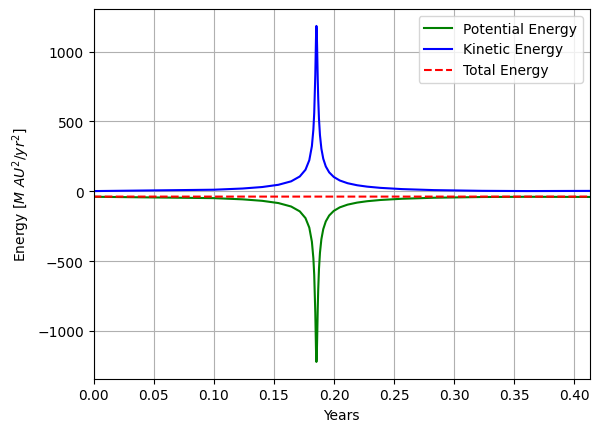

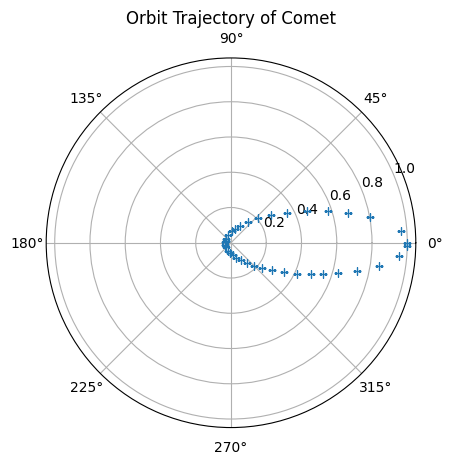

In [11]:
# intial conditions and parameters
r0 = 1                 # AU
r = np.array([r0, 0]) 
v0 = np.pi /2            # AU/yr
v = np.array([0, v0])        
GM = 4 * np.pi**2     # AU^3/yr^2
m = 1                 # set comet mass to unity
tau = 0.1            # years
steps = 800

adapt_err = 1.e-3

orbit_type = 'El'       # 'El' for elliptical, 'Ci' for circular. Use theory to detrmine required velocity and r0.
Method = 'RKA'         # E for Euler, EC for Euler-Cromer, V for Verlet
time = 0.0
count = 0
stepCount = 0

states = np.array([r[0], r[1], v[0], v[1]])       # state vector to pass to gravrk

# Backstep to initiate Verlet scheme:
accel = -GM * r / np.linalg.norm(r)**3
backStep = r - tau*v + (tau**2)/2 * accel

# Set-up arrays to record data
rPlot = np.empty(steps)
thetaPlot = np.empty(steps)
kinetic = np.empty(steps)
potential = np.empty(steps)
tPlot = np.empty(steps)


for i in range(steps):
    stepCount += 1
    # Save values from last iteration
    rPlot[i] = np.linalg.norm(r)
    thetaPlot[i] = np.arctan2(r[1],r[0])
    potential[i] = -GM * m / np.linalg.norm(r)
    kinetic[i] = 0.5 * m * np.linalg.norm(v)**2
    tPlot[i] = time
    accel = -GM * r / np.linalg.norm(r)**3      # All methods use acceleration in the same way so can take out of if statements

    # Numerical Scheme
    if Method == 'E': 
        r = r + tau * v
        v = v + tau * accel
        time = i * tau

    if Method == 'EC':
        v = v + tau * accel
        r = r + tau * v         # Only difference is the r equation uses the updated v, this improves results
        time = i * tau

    if Method == 'V':
        # Use back step to initiate the Verlet method
        r_new = 2*r - backStep + tau**2 * accel            # new position r_{n+1}
        v = (r_new - backStep) /(2*tau)
        backStep = r        # set up new backstep for next step (r_{n-1})
        r = r_new           # rn (current r) for next step
        time = i * tau
    
    if Method == 'RK4':
        states = rk4(states, time, tau, gravrk, GM)
        r = np.array([states[0], states[1]])
        v = np.array([states[2], states[3]])
        time = i * tau

    if Method == 'RKA':
        states, time, tau = rka(states, time, tau, adapt_err, gravrk, GM)
        r = np.array([states[0], states[1]])
        v = np.array([states[2], states[3]])

    if thetaPlot[i]*thetaPlot[i-1] < 0:
        count += 1
        if count == 2:
            period = tPlot[i]
            break
    else:
        period = 0

total_E = potential + kinetic

a = np.max(rPlot[:stepCount])
b = np.min(rPlot[:stepCount])
e = np.sqrt(1 - (b**2/a**2))
delta_E = ((max(total_E[:stepCount]) - min(total_E[:stepCount])) / total_E[0]) * 100
if orbit_type == 'Ci':
    E_theory = (-GM * m) / (2*np.linalg.norm(r))
elif orbit_type == 'El':
    E_theory = (-GM * m) / (2*a)       # for elliptical we use the semi-major radius

L = np.cross(r, m * v)      # angular momentum for e theory
e_theory = np.sqrt(1 + (2 * E_theory * np.linalg.norm(L)**2)/(GM**2 * m**3))
e_error = (e - e_theory) / e * 100


print(f'Method used is {Method}')
# print(f'The orbital period is {period:.2f} Years')  
print(f'The semi-minor axis is {b:.3f} AU')
print(f'The semi-major axis is {a:.3f} AU')
print(f'The eccentricity is {e:.3f}')
print(f'The theoretical eccentricity is {e_theory:.3f}')
print(f'The error in the eccentricity is {e_error:.3f} %')
print(f'Change in total energy {delta_E:.3f} %')            

plt.plot(tPlot[:stepCount], potential[:stepCount], 'g-', label='Potential Energy')
plt.plot(tPlot[:stepCount], kinetic[:stepCount], 'b-', label='Kinetic Energy')
plt.plot(tPlot[:stepCount], total_E[:stepCount], 'r--', label='Total Energy')
plt.xlabel('Years'); plt.ylabel('Energy [$M$ $AU^2 / yr^2$]')
plt.xlim((0, tPlot[stepCount-1]))
plt.grid()
plt.legend()
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection':'polar'})
ax.plot(thetaPlot[:stepCount], rPlot[:stepCount],'+' )
ax.set_title('Orbit Trajectory of Comet')
plt.show()